<a href="https://colab.research.google.com/github/dscohen75/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [31]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                 parse_dates=['Date'],
                 index_col='Date'
                 )

In [32]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [33]:
df.head(15)

,Location,Burrito,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Donato's taco shop,California,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.00,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Oscar's Mexican food,California,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.50,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Oscar's Mexican food,Carnitas,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.50,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Oscar's Mexican food,Carne asada,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.50,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-27,Pollos Maria,California,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.00,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2016-01-28,Pollos Maria,combo chicken,NaN,NaN,NaN,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.00,3.5,2.5,2.5,2.5,4.0,1.0,3.20,NaN,Emily,NaN,NaN,NaN,NaN,NaN,x,x,NaN,x,NaN,x,NaN,NaN,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-30,Nico's Taco Shop,California,Carmel Valley,3860 Valley Centre Dr #404,http://www.yelp.com/biz/nicos-taco-shop-san-diego,3.0,2.9,NaN,7.19,1.5,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.00,2.0,2.5,2.5,NaN,2.0,3.0,2.60,NaN,Scott,not fries. big potatoes,NaN,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-30,Nico's Taco Shop,Carnitas,NaN,NaN,NaN,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,2.5,3.0,3.00,2.5,3.0,3.5,NaN,2.5,3.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-02-01,Los Primos Mexican Food,Monster California,UTC,7770 Regents Rd,http://www.primosmex.com/,3.0,3.7,x,9.25,3.5,NaN,NaN,NaN,NaN,NaN,2.0,4.5,4.50,3.5,1.5,3.0,3.5,4.0,2.0,3.90,NaN,Scott,this tasted really bad leftover. not included ...,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [34]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [7]:
df['Neighborhood'].nunique()

41

In [9]:
df.shape

(421, 67)

In [35]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [36]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           26 non-null     object 
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

In [15]:
df['Great'].value_counts()


False    239
True     182
Name: Great, dtype: int64

In [38]:
df['Great'] = df['Great'].astype(int)

In [40]:
df['Great'].value_counts()

0    239
1    182
Name: Great, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Burrito         421 non-null    object        
 1   Date            421 non-null    datetime64[ns]
 2   Yelp            87 non-null     float64       
 3   Google          87 non-null     float64       
 4   Chips           26 non-null     object        
 5   Cost            414 non-null    float64       
 6   Hunger          418 non-null    float64       
 7   Mass (g)        22 non-null     float64       
 8   Density (g/mL)  22 non-null     float64       
 9   Length          283 non-null    float64       
 10  Circum          281 non-null    float64       
 11  Volume          281 non-null    float64       
 12  Tortilla        421 non-null    float64       
 13  Temp            401 non-null    float64       
 14  Meat            407 non-null    float64       
 15  Fillin

In [41]:
y = df['Great']
X = df[['Burrito','Cost','Hunger','Length','Circum','Volume',\
       'Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity',\
       'Salsa','Synergy','Wrap']]

In [42]:
y.shape

(421,)

In [43]:
X.shape

(421, 15)

In [45]:
# Use 2016 and prior to train
# Use 2017 to validate
# Use 2018 to test

cutoff1 = '2017-01-01'
cutoff2 = '2017-12-31'
mask1 = df.index < cutoff1
mask2 = (df.index >= cutoff1) & (df.index <= cutoff2)
mask3 = df.index > cutoff2

X_train, y_train = X.loc[mask1], y.loc[mask1]
X_val, y_val = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[mask3], y.loc[mask3]

In [46]:
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0]

In [53]:
print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.5906040268456376


In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298 entries, 2016-01-18 to 2016-12-15
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Burrito       298 non-null    object 
 1   Cost          292 non-null    float64
 2   Hunger        297 non-null    float64
 3   Length        175 non-null    float64
 4   Circum        174 non-null    float64
 5   Volume        174 non-null    float64
 6   Tortilla      298 non-null    float64
 7   Temp          283 non-null    float64
 8   Meat          288 non-null    float64
 9   Fillings      297 non-null    float64
 10  Meat:filling  292 non-null    float64
 11  Uniformity    296 non-null    float64
 12  Salsa         278 non-null    float64
 13  Synergy       296 non-null    float64
 14  Wrap          296 non-null    float64
dtypes: float64(14), object(1)
memory usage: 37.2+ KB


## Build the model

In [78]:
#Pipeline

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Step 1: Instantiate our pipeline

model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

# Step 2. Fit the model to the training data

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                     

In [79]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.8859060402684564
Validation Accuracy: 0.8


In [60]:
model.named_steps

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'onehotencoder': OneHotEncoder(cols=['Burrito'], drop_invariant=False, handle_missing='value',
               handle_unknown='value', return_df=True, use_cat_names=False,
               verbose=0),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='mean', verbose=0)}

In [66]:
model.named_steps['logisticregression'].coef_

array([[ 0.38734033,  0.71117727, -0.14895138, -0.59552405, -1.34687541,
         0.34067252,  0.0070472 , -0.10494276, -0.40502239,  1.31715986,
         0.89115482,  0.32229857,  1.17973701,  1.0177611 ,  0.98262288,
         0.0568952 ,  0.284647  ,  1.72772503,  0.00711439]])

In [70]:
model.named_steps['onehotencoder'].get_feature_names(['Burrito'])

TypeError: ignored

In [72]:
model.named_steps['onehotencoder'].get_feature_names()

['Burrito_1',
 'Burrito_2',
 'Burrito_3',
 'Burrito_4',
 'Burrito_5',
 'Cost',
 'Hunger',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap']

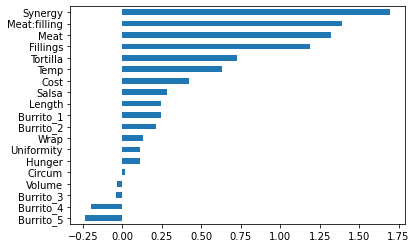

In [80]:
pd.Series(model.named_steps['logisticregression'].coef_[0], 
          index=model.named_steps['onehotencoder'].get_feature_names()
          ).sort_values().plot(kind='barh');